/tmp/ipykernel_21946/796001363.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


[1.4, 1.4, 1.62, 1.62, 1.4]
[-0.08, -0.08, 0.08499999999999999, 0.08499999999999999, -0.08]
[(1, 0.58290399936), (2, 0.58291110152), (3, 0.58292162272), (5, 0.5829396032), (6, 0.58294936288), (7, 0.58295429496), (8, 0.58295924336), (9, 0.58296410432), (10, 0.58298328128), (11, 0.5830065936), (12, 0.5830248256), (13, 0.58303382464), (14, 0.58304725792), (15, 0.58305176512), (16, 0.5830741424), (17, 0.58307859216), (18, 0.58308305312), (19, 0.58308751744), (20, 0.58309648368), (22, 0.5831099744), (23, 0.58312332128), (24, 0.58314125688), (25, 0.58314586048), (26, 0.58315521264), (28, 0.58316905472), (29, 0.58318281472), (30, 0.58318732672), (31, 0.583209796), (32, 0.58321431136), (33, 0.58323239968), (34, 0.58323695744), (35, 0.5832688008), (36, 0.58327331488), (37, 0.5832778728), (38, 0.58328244096), (39, 0.58329156096), (40, 0.58330096), (41, 0.58333747584), (42, 0.58335584544), (43, 0.5833650064), (44, 0.58338299616), (45, 0.58338748192), (46, 0.58340128224), (47, 0.58341062376), (48,

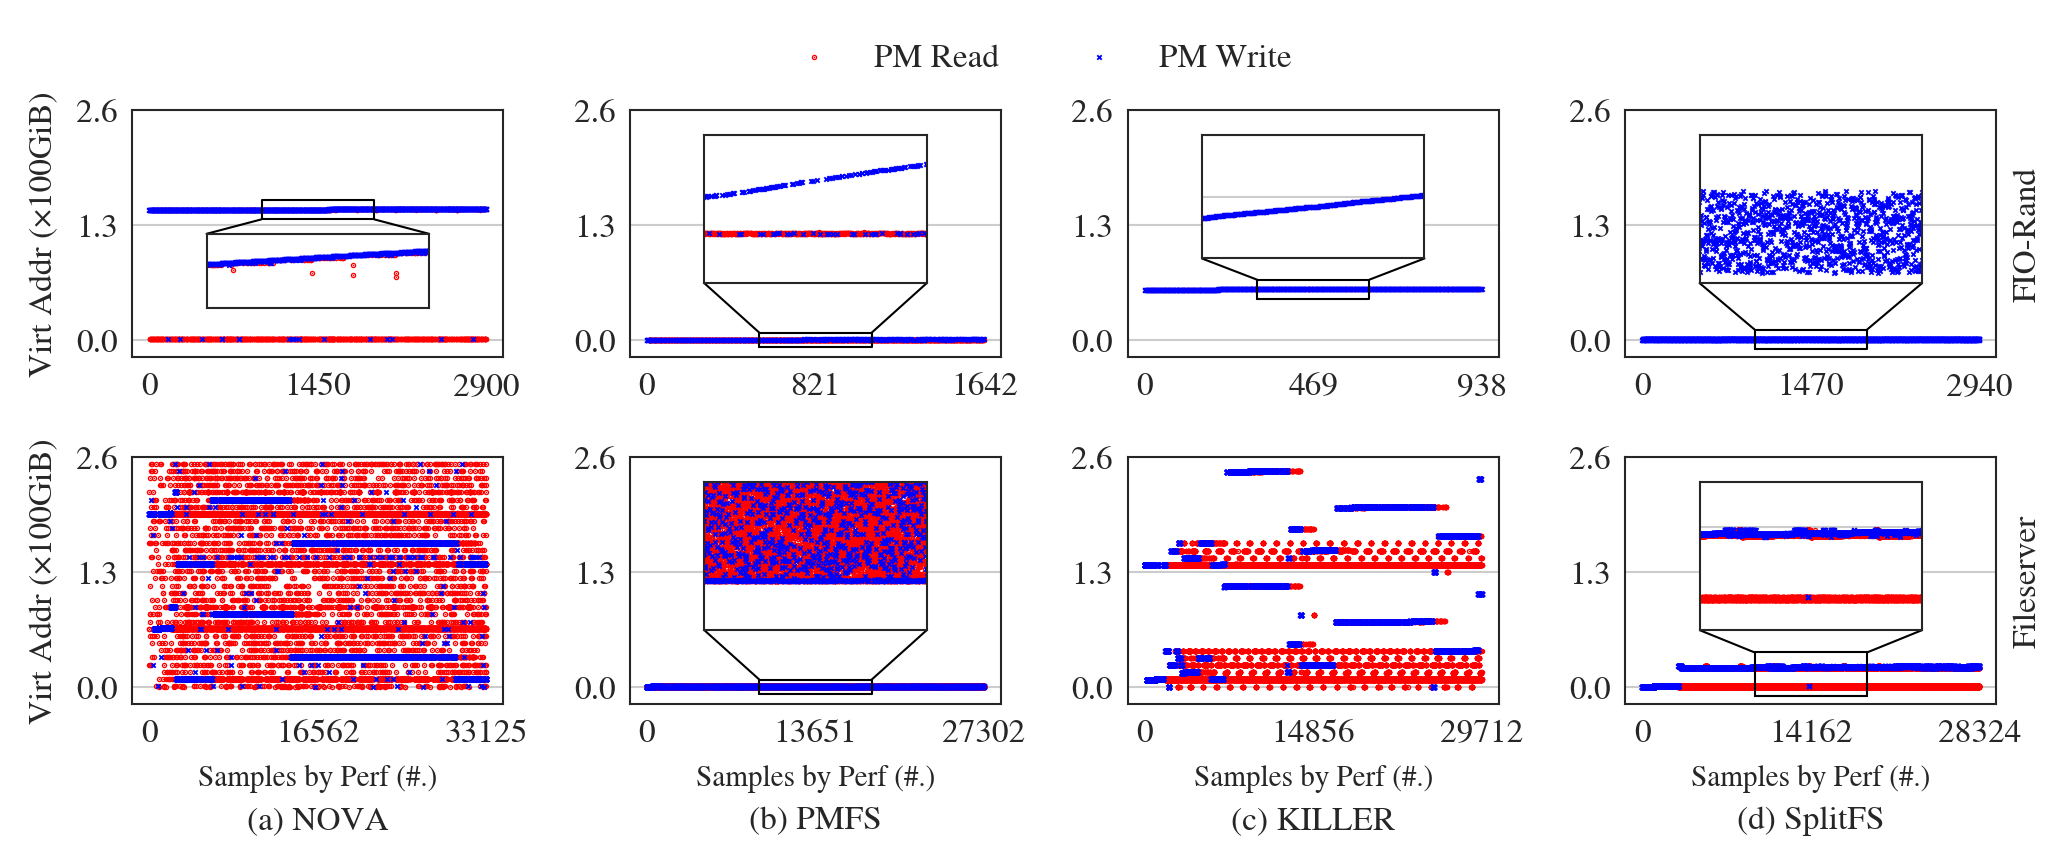

In [1]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
# with open("./performance-comparison-table", "r") as f:
#     df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(7)))

# fss = ["NOVA", "PMFS", "KILLER", "SplitFS-FILEBENCH", "EXT4-DAX", "XFS-DAX"]
fss = ["NOVA", "PMFS", "KILLER", "SplitFS-FILEBENCH"]
# fss_remaps = ["NOVA", "PMFS", "KILLER", "SplitFS", "EXT4-DAX", "XFS-DAX"]
fss_remaps = ["(a) NOVA", "(b) PMFS", "(c) KILLER", "(d) SplitFS"]
# workloads = [ "fio-seq", "fio-rand", "fileserver.f", "varmail.f", "webproxy.f", "webserver.f" ]
workloads = [ "fio-rand", "fileserver.f" ]
# workloads_remap = [ "(a) FIO-Seq", "(b) FIO-Rand", "(c) Fileserver", "(d) Varmail", "(e) Webproxy", "(f) Webserver" ]
workloads_remap = [ "FIO-Rand", "Fileserver" ]

pics_filter = [ 4, 6
                # 2, 3, 4, 5,
                # 14, 15, 16, 17,
                # 20, 21, 22, 23,
                # 26, 27, 28, 29,
                # 32, 33, 35
                ]
def format_ax_yticks(ax, yticks_low, y_ticks_high, points, valid_numbers):
    yticks = np.linspace(yticks_low, y_ticks_high, points)
    ax.set_yticks(yticks)
    min_valid_numbers = 0
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        if len(integer_numbers) > min_valid_numbers:
            min_valid_numbers = len(integer_numbers)
    
    valid_numbers = valid_numbers if valid_numbers > min_valid_numbers else min_valid_numbers
    new_yticks = []
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        decimal_numbers = ytick.split('.')[1]
        if len(decimal_numbers) < (valid_numbers - len(integer_numbers)):
            new_ytick = integer_numbers + '.' + decimal_numbers + '0' * (valid_numbers - len(integer_numbers) - len(decimal_numbers))
        else:
            new_ytick = integer_numbers + '.' + ytick.split('.')[1][:(valid_numbers - len(integer_numbers))]
        new_yticks.append(new_ytick)
    # print(yticks)
    # print(new_yticks)
    ax.set_yticklabels(new_yticks, fontsize=8)

def zoom_in(axins, x, ys, zone_left, zone_right):
    # 坐标轴的扩展比例（根据实际数据调整）
    x_ratio = 0.1 # x轴显示范围的扩展比例
    y_ratio = 0.1 # y轴显示范围的扩展比例

    # X轴的显示范围
    xlim0 = x[zone_left]-(x[zone_right]-x[zone_left])*x_ratio
    xlim1 = x[zone_right]+(x[zone_right]-x[zone_left])*x_ratio

    stack = []
    for y in ys:
        stack.append(y[zone_left:zone_right])
    y = np.hstack(stack)
    ylim0 = np.min(y)-(np.max(y)-np.min(y))*y_ratio
    ylim1 = np.max(y)+(np.max(y)-np.min(y))*y_ratio

    # 调整子坐标系的显示范围
    axins.set_xlim(xlim0, xlim1)
    axins.set_ylim(0, ylim1)
    return (xlim0, xlim1, 0, ylim1)

read_point_line = None
write_point_line = None

gs = gridspec.GridSpec(len(workloads), len(fss), hspace=0.4, wspace=0.2)
for workload_idx, workload in enumerate(workloads):
    for fs_idx, fs in enumerate(fss):
        subfig = plt.subplot(gs[workload_idx, fs_idx])
        read_points = []
        write_points = []
        
        pic_id = workload_idx * len(fss) + fs_idx

        with open("./PERF_DATA/%s/perf_report_filtered-%s" % (fs, workload), "r") as f:
            lines = f.readlines()
            access_times = 1
            for line_id, line in enumerate(lines):
                # if workload.startswith("fio") and line_id % 10 != 0:
                #     continue
                # if not workload.startswith("fio") and line_id % 100 != 0:
                #     continue
                if line.startswith("Filter Range"):
                    virt_start = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[0], 16)
                    virt_end = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[1], 16)
                elif line.startswith("read"):
                    read_points.append((access_times, int(line.split(":")[-1].strip(), 16) - virt_start))
                    access_times += 1
                elif line.startswith("write"):
                    write_points.append((access_times, int(line.split(":")[-1].strip(), 16) - virt_start))
                    access_times += 1
        
        # print(read_points)
        read_points = [(x[0], x[1] / 100_000_000_000) for x in read_points]
        write_points = [(x[0], x[1] / 100_000_000_000) for x in write_points]
        r = plt.scatter([x[0] for x in read_points], [x[1] for x in read_points], marker='o', s=0.1, color='red')
        w = plt.scatter([x[0] for x in write_points], [x[1] for x in write_points], marker='x', s=0.1, color='blue')
        if read_point_line is None:
            read_point_line = r
        if write_point_line is None:
            write_point_line = w
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        
        # plt.yticks(, fontsize=8)
        plt.ylim(-0.2, (virt_end - virt_start) / 100_000_000_000)
        plt.xticks(np.linspace(0, access_times, 3), fontsize=8)
        # plt.yticks(np.linspace(0, (virt_end - virt_start) / 100_000_000_000, 3), fontsize=6)
        format_ax_yticks(ax, 0, (virt_end - virt_start) / 100_000_000_000, 3, 2)
        if workload_idx == len(workloads) - 1:
            plt.xlabel(fss_remaps[fs_idx], fontsize=8, labelpad=14)
            # if workload.startswith("fio"):
            #     subfig.text(0.5, -0.45, "Sample (#.)", ha='center', va='center', fontsize=8, transform=subfig.transAxes)
            # else:
            #     subfig.text(0.5, -0.45, "Sample (×10)", ha='center', va='center', fontsize=8, transform=subfig.transAxes)
            subfig.text(0.5, -0.3, "Samples by Perf (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)

        if fs_idx == 0:
            plt.ylabel("Virt Addr (×100GiB)", fontsize=8)
            # plt.title(subfig_titles[workload_idx], fontsize=8)
        
        if fs_idx == 3:
            plt.ylabel(workloads_remap[workload_idx], fontsize=8)
            ax.yaxis.set_label_position("right")
        
        # Zoom
        if pic_id not in pics_filter:
            # custom configures
            axins_x0 = 0.2
            axins_y0 = 0.3
            axins_width = 0.6
            axins_height = 0.6
            pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 3, 2, 4, 1 
            if fs == "KILLER":
                if workload == "fio-seq":
                    ylim_left = 0.335
                    ylim_right = 0.345
                else:
                    ylim_left = 0.58
                    ylim_right = 0.6
                    print(write_points)
                    axins_y0 += 0.1
                    axins_height -= 0.1
            elif fs == "NOVA":
                if workload == "fio-seq":
                    ylim_left = 0.68
                    ylim_right = 0.685
                    axins_y0 += 0.1
                    axins_height -= 0.1
                else:
                    ylim_left = 1.5
                    ylim_right = 1.52
                    axins_y0 -= 0.1
                    axins_height = 0.3
                    pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 2, 3, 1, 4
            elif fs == "PMFS":
                ylim_left = -0.005    
                ylim_right = 0.01
            elif fs == "SplitFS-FILEBENCH":
                ylim_left = 0    
                ylim_right = 0.02
                if workload == "fileserver.f":
                    ylim_left = -0.1
                    ylim_right = 0.4
                if workload == "varmail.f":
                    ylim_left = 0.56
                    ylim_right = 0.57
                    axins_y0 += 0.1
                    axins_height -= 0.1
                if workload == "webproxy.f":
                    ylim_left = 1.36
                    ylim_right = 1.39
                    axins_y0 -= 0.2
                    axins_height = 0.3
                    pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 2, 3, 1, 4
                    
                if workload == "webserver.f":
                    ylim_left = -0.1
                    ylim_right = 0.2
                    axins_y0 += 0.1
                    axins_height -= 0.1
                    
            elif fs == "EXT4-DAX":
                ylim_left = 0    
                ylim_right = 0.02
                if workload == "fileserver.f":
                    ylim_left = 0.52
                    ylim_right = 0.54
                    axins_y0 += 0.1
                    axins_height -= 0.1
                    print(write_points)
                if workload == "varmail.f":
                    ylim_left = 0.19
                    ylim_right = 0.21
                    print(write_points)
                    
                if workload == "webproxy.f":
                    ylim_left = 0.067
                    ylim_right = 0.08
                    print(write_points)
                    
                if workload == "webserver.f":
                    ylim_left = -0.1
                    ylim_right = 0.3
                    print(write_points)
                    
            elif fs == "XFS-DAX":
                ylim_left = 0    
                ylim_right = 0.02
                if workload == "webproxy.f":
                    ylim_left = 0.66
                    ylim_right = 0.67
                    axins_y0 += 0.1
                    axins_height -= 0.1
                    print(write_points)
                    
            else:
                ylim_left = 0    
                ylim_right = 0.02
            
            # start to plot
            axins = ax.inset_axes((axins_x0, axins_y0, axins_width, axins_height))
            
            axins.scatter([x[0] for x in read_points], [x[1] for x in read_points], marker='o', s=0.1, color='red')
            axins.scatter([x[0] for x in write_points], [x[1] for x in write_points], marker='x', s=0.1, color='blue')
            for tick in axins.get_yaxis().get_major_ticks():
                tick.set_pad(1)
            for tick in axins.get_xaxis().get_major_ticks():
                tick.set_pad(1)
            lw = 0.5
            for axis in ['top','bottom','left','right']:
                axins.spines[axis].set_linewidth(lw)

            # tx0, tx1, ty0, ty1 = zoom_in(axins, [x[0] for x in read_points], [x[1] for x in read_points], len(tail_latency_percentiles) - 5, len(tail_latency_percentiles) - 1)
            
            axins.set_ylim(ylim_left, ylim_right)
            axins.set_yticklabels([])
            # if not workload.startswith("fio"):
            #     axins.set_xlim(access_times / 3, access_times / 3 + 1200)
            #     axins.set_xticklabels([])
            # else: 
            xlim_left = access_times / 3
            xlim_right = access_times * 2 / 3
            axins.set_xlim(xlim_left, xlim_right)
            axins.set_xticklabels([])
            # axins.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1f'))
            # axins.set_xticks(np.linspace(len(tail_latency_percentiles) - 4, len(tail_latency_percentiles), 5))
            if pic_id == 7:
                patch, pp1, pp2 = mark_inset(ax, axins, loc1 = 3, loc2 = 4, fc="none", ec='k', lw=0.5)
                pp1.loc1 = pp1_loc1
                pp1.loc2 = pp1_loc2
                pp2.loc1 = pp2_loc1
                pp2.loc2 = pp2_loc2    
            else:
                origin_ylim_left, origin_ylim_right = ylim_left, ylim_right

                height = ylim_right - ylim_left
                delta = 5 * height
                ylim_left -= delta
                ylim_right += delta

                ax.plot([xlim_left, xlim_right, xlim_right, xlim_left, xlim_left], [ylim_left, ylim_left, ylim_right, ylim_right, ylim_left], color='k', lw=0.5, zorder=2)

                print([ylim_left, ylim_left, ylim_right, ylim_right, ylim_left])
                if [pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2] == [3, 2, 4, 1]:
                    xy = (xlim_left, ylim_right)
                    xy2 = (xlim_left, origin_ylim_left)
                    con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                            axesA=axins,axesB=ax, lw=0.5)
                    axins.add_artist(con)

                    xy = (xlim_right, ylim_right)
                    xy2 = (xlim_right, origin_ylim_left)
                    con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                            axesA=axins,axesB=ax, lw=0.5)
                    axins.add_artist(con)
                elif [pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2] == [2, 3, 1, 4]:
                    xy = (xlim_left, ylim_left)
                    xy2 = (xlim_left, origin_ylim_right)
                    con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                            axesA=axins,axesB=ax, lw=0.5)
                    axins.add_artist(con)

                    xy = (xlim_right, ylim_left)
                    xy2 = (xlim_right, origin_ylim_right)
                    con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                            axesA=axins,axesB=ax, lw=0.5)
                    axins.add_artist(con)

# legend_labels = fss
fig.legend([r, w], ["PM Read", "PM Write"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=8, frameon=False)
# plt.tight_layout()
gs.tight_layout(fig)
plt.savefig("./FIG-Pattern.pdf", bbox_inches='tight', pad_inches=0)
plt.savefig("./FIG-Pattern.svg", bbox_inches='tight', pad_inches=0)
plt.savefig("./FIG-Pattern.png", bbox_inches='tight', pad_inches=0)


# New Plot

/tmp/ipykernel_21946/738552396.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  style.use('seaborn-white')


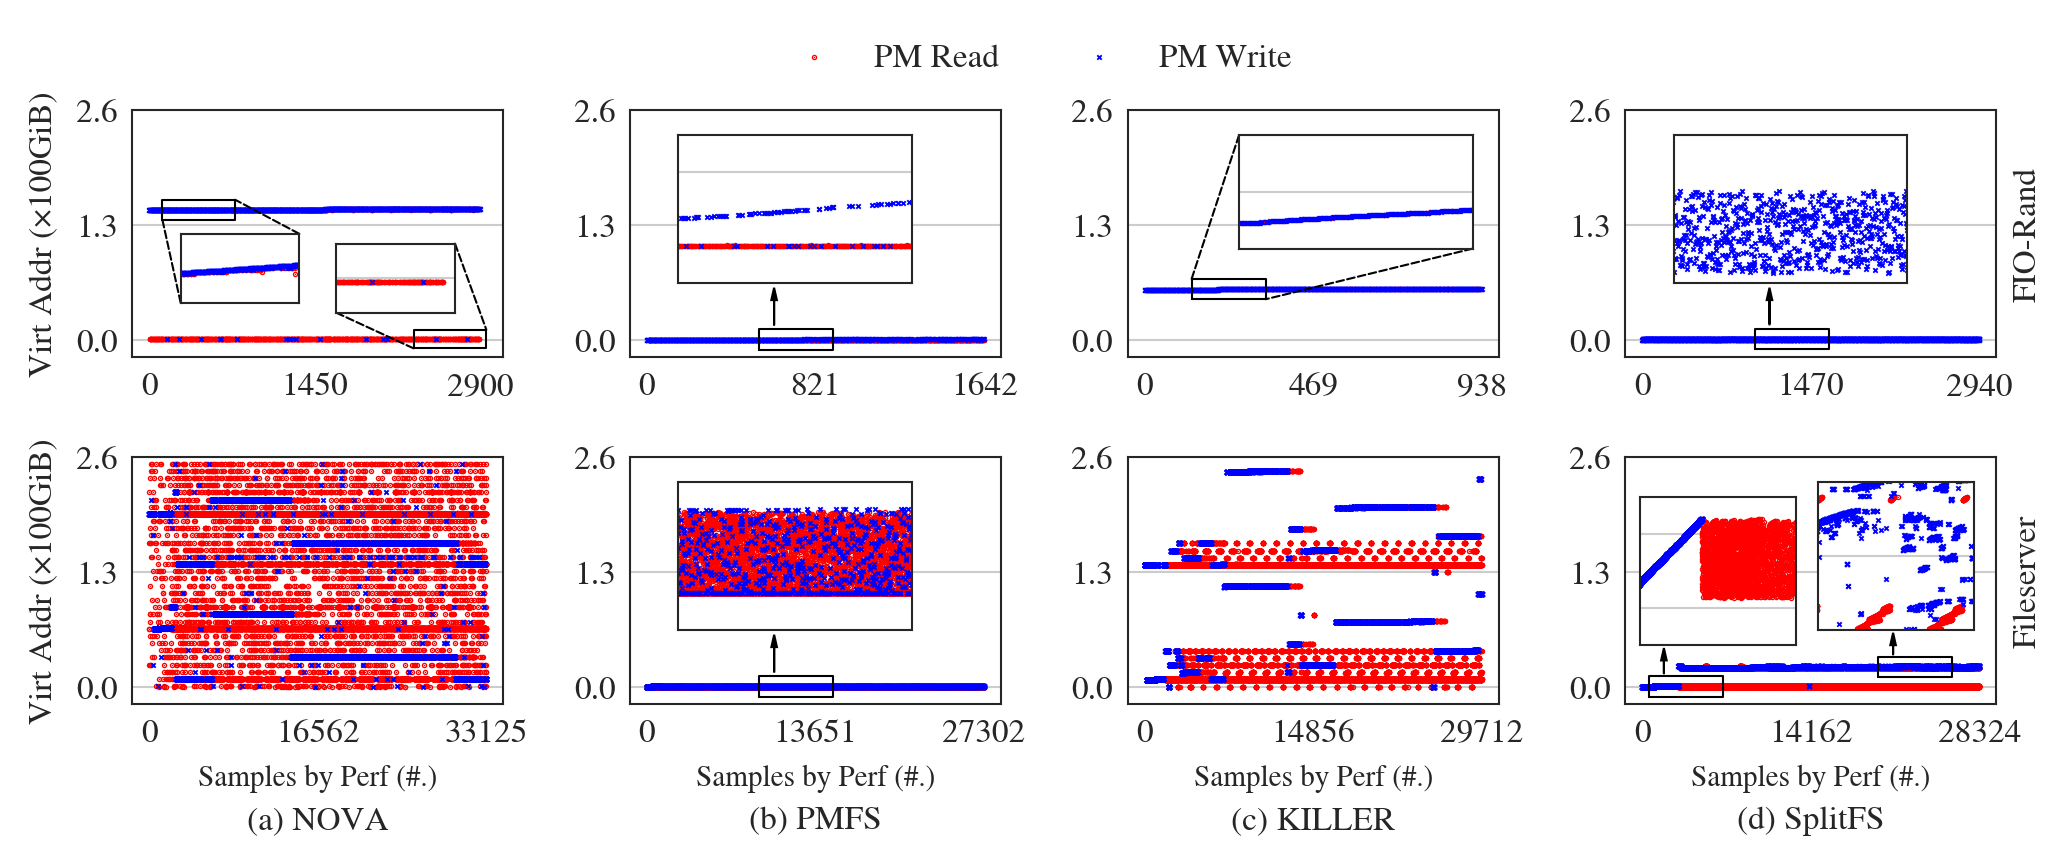

In [3]:
# ipython -c "%run plot.ipynb"

import matplotlib
from matplotlib.patches import ConnectionPatch
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd
import matplotlib.gridspec as gridspec
import numpy as np
import matplotlib.ticker as mtick
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

# Paper specific settings
STANDARD_WIDTH = 17.8
SINGLE_COL_WIDTH = STANDARD_WIDTH / 2
DOUBLE_COL_WIDTH = STANDARD_WIDTH
def cm_to_inch(value):
    return value/2.54
    
# matplotlib style settings
matplotlib.rcParams['text.usetex'] = False
style.use('seaborn-white')
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.grid.axis"] = "y"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams['hatch.linewidth'] = 0.5
plt.rcParams["font.family"] = "Nimbus Roman"
pd.options.display.max_columns = None
pd.options.display.max_rows = None


# Data Preprocessing
# with open("./avg-test-result-in-paper", "r") as f:
# with open("./performance-comparison-table", "r") as f:
#     df = pd.read_csv(f, delim_whitespace=True, index_col=None, engine='python')

# Plotting Settings
fig = plt.figure(dpi = 300, figsize = (cm_to_inch(DOUBLE_COL_WIDTH), cm_to_inch(7)))

# fss = ["NOVA", "PMFS", "KILLER", "SplitFS-FILEBENCH", "EXT4-DAX", "XFS-DAX"]
fss = ["NOVA", "PMFS", "KILLER", "SplitFS-FILEBENCH"]
# fss_remaps = ["NOVA", "PMFS", "KILLER", "SplitFS", "EXT4-DAX", "XFS-DAX"]
fss_remaps = ["(a) NOVA", "(b) PMFS", "(c) KILLER", "(d) SplitFS"]
# workloads = [ "fio-seq", "fio-rand", "fileserver.f", "varmail.f", "webproxy.f", "webserver.f" ]
workloads = [ "fio-rand", "fileserver.f" ]
# workloads_remap = [ "(a) FIO-Seq", "(b) FIO-Rand", "(c) Fileserver", "(d) Varmail", "(e) Webproxy", "(f) Webserver" ]
workloads_remap = [ "FIO-Rand", "Fileserver" ]

pics_filter = [ 4, 6
                # 2, 3, 4, 5,
                # 14, 15, 16, 17,
                # 20, 21, 22, 23,
                # 26, 27, 28, 29,
                # 32, 33, 35
                ]
def format_ax_yticks(ax, yticks_low, y_ticks_high, points, valid_numbers):
    yticks = np.linspace(yticks_low, y_ticks_high, points)
    ax.set_yticks(yticks)
    min_valid_numbers = 0
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        if len(integer_numbers) > min_valid_numbers:
            min_valid_numbers = len(integer_numbers)
    
    valid_numbers = valid_numbers if valid_numbers > min_valid_numbers else min_valid_numbers
    new_yticks = []
    for ytick in yticks:
        ytick = str(float(ytick))
        integer_numbers = ytick.split('.')[0]
        decimal_numbers = ytick.split('.')[1]
        if len(decimal_numbers) < (valid_numbers - len(integer_numbers)):
            new_ytick = integer_numbers + '.' + decimal_numbers + '0' * (valid_numbers - len(integer_numbers) - len(decimal_numbers))
        else:
            new_ytick = integer_numbers + '.' + ytick.split('.')[1][:(valid_numbers - len(integer_numbers))]
        new_yticks.append(new_ytick)
    # print(yticks)
    # print(new_yticks)
    ax.set_yticklabels(new_yticks, fontsize=8)


def zoom_in(ax, axins, x_ratio, y_ratio, x_start, y_start, 
            zoom_height, zoom_style,
            connect_ax_first_loc, connect_ax_second_loc, connect_axins_first_loc, connect_axins_second_loc, 
            axins_x0, axins_y0):
    # 1: 左上, 2: 左下, 3: 右上, 4: 右下
    x_lim_left, x_lim_right = ax.get_xlim()
    y_lim_left, y_lim_right = ax.get_ylim()

    xlim_left = x_start
    xlim_right = x_start + x_ratio * (x_lim_right - x_lim_left)
    ylim_left = y_start
    ylim_right = y_start + y_ratio * (y_lim_right - y_lim_left)

    axins.set_xlim(xlim_left, xlim_right)
    axins.set_ylim(ylim_left, ylim_right)

    zoom_xlim_left = xlim_left
    zoom_xlim_right = xlim_right
    zoom_ylim_left = ylim_left - zoom_height * (y_lim_right - y_lim_left)
    zoom_ylim_right = ylim_right + zoom_height * (y_lim_right - y_lim_left)
    
    ax.plot([zoom_xlim_left, zoom_xlim_right, zoom_xlim_right, zoom_xlim_left, zoom_xlim_left], 
            [zoom_ylim_left, zoom_ylim_left, zoom_ylim_right, zoom_ylim_right, zoom_ylim_left], 
            color='k', lw=0.5, zorder=2)
    
    def get_ax_connect_point(connect_loc):
        if connect_loc == 1:
            return (zoom_xlim_left, zoom_ylim_right)
        elif connect_loc == 2:
            return (zoom_xlim_left, zoom_ylim_left)
        elif connect_loc == 3:
            return (zoom_xlim_right, zoom_ylim_right)
        elif connect_loc == 4:
            return (zoom_xlim_right, zoom_ylim_left)
        
    def get_axins_connect_point(connect_loc):
        if connect_loc == 1:
            return (xlim_left, ylim_right)
        elif connect_loc == 2:
            return (xlim_left, ylim_left)
        elif connect_loc == 3:
            return (xlim_right, ylim_right)
        elif connect_loc == 4:
            return (xlim_right, ylim_left)

    if zoom_style == "line":
        xy = get_ax_connect_point(connect_ax_first_loc)
        xy2 = get_axins_connect_point(connect_axins_first_loc)
        con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                axesA=axins,axesB=ax, lw=0.5, linestyle="--")
        axins.add_artist(con)

        xy = get_ax_connect_point(connect_ax_second_loc)
        xy2 = get_axins_connect_point(connect_axins_second_loc)
        con = ConnectionPatch(xyA=xy2,xyB=xy,coordsA="data",coordsB="data",
                axesA=axins,axesB=ax, lw=0.5, linestyle="--")
        axins.add_artist(con)

    elif zoom_style == "arrow":
        left_margin = zoom_xlim_left + 0.2 * (zoom_xlim_right - zoom_xlim_left)
        # get y pos of axins
        lower_y = y_lim_left + axins_y0 * (y_lim_right - y_lim_left)
        arrow_length = lower_y - zoom_ylim_right
        gap = 0.1 * arrow_length
        
        # draw an arrow from ax to axins
        ax.arrow(left_margin, zoom_ylim_right + gap, 
                 0, arrow_length - 2 * gap,
                 length_includes_head=True,
                 head_width=0.015 * (x_lim_right - x_lim_left), 
                 head_length=0.05 * (y_lim_right - y_lim_left),
                 fc='k', ec='k', linewidth=0.5)

read_point_line = None
write_point_line = None

gs = gridspec.GridSpec(len(workloads), len(fss), hspace=0.4, wspace=0.2)
for workload_idx, workload in enumerate(workloads):
    for fs_idx, fs in enumerate(fss):
        subfig = plt.subplot(gs[workload_idx, fs_idx])
        read_points = []
        write_points = []
        
        pic_id = workload_idx * len(fss) + fs_idx

        with open("./PERF_DATA/%s/perf_report_filtered-%s" % (fs, workload), "r") as f:
            lines = f.readlines()
            access_times = 1
            for line_id, line in enumerate(lines):
                # if workload.startswith("fio") and line_id % 10 != 0:
                #     continue
                # if not workload.startswith("fio") and line_id % 100 != 0:
                #     continue
                if line.startswith("Filter Range"):
                    virt_start = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[0], 16)
                    virt_end = int(" ".join(line.split(" ")).split(" ")[2].strip().split("-")[1], 16)
                elif line.startswith("read"):
                    read_points.append((access_times, int(line.split(":")[-1].strip(), 16) - virt_start))
                    access_times += 1
                elif line.startswith("write"):
                    write_points.append((access_times, int(line.split(":")[-1].strip(), 16) - virt_start))
                    access_times += 1
        
        # print(read_points)
        read_points = [(x[0], x[1] / 100_000_000_000) for x in read_points]
        write_points = [(x[0], x[1] / 100_000_000_000) for x in write_points]
        r = plt.scatter([x[0] for x in read_points], [x[1] for x in read_points], marker='o', s=0.1, color='red')
        w = plt.scatter([x[0] for x in write_points], [x[1] for x in write_points], marker='x', s=0.1, color='blue')
        if read_point_line is None:
            read_point_line = r
        if write_point_line is None:
            write_point_line = w
        ax = fig.gca()
        lw = 0.5
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(lw)
        
        # plt.yticks(, fontsize=8)
        plt.ylim(-0.2, (virt_end - virt_start) / 100_000_000_000)
        plt.xticks(np.linspace(0, access_times, 3), fontsize=8)
        # plt.yticks(np.linspace(0, (virt_end - virt_start) / 100_000_000_000, 3), fontsize=6)
        format_ax_yticks(ax, 0, (virt_end - virt_start) / 100_000_000_000, 3, 2)
        if workload_idx == len(workloads) - 1:
            plt.xlabel(fss_remaps[fs_idx], fontsize=8, labelpad=14)
            # if workload.startswith("fio"):
            #     subfig.text(0.5, -0.45, "Sample (#.)", ha='center', va='center', fontsize=8, transform=subfig.transAxes)
            # else:
            #     subfig.text(0.5, -0.45, "Sample (×10)", ha='center', va='center', fontsize=8, transform=subfig.transAxes)
            subfig.text(0.5, -0.3, "Samples by Perf (#.)", ha='center', va='center', fontsize=7, transform=subfig.transAxes)

        if fs_idx == 0:
            plt.ylabel("Virt Addr (×100GiB)", fontsize=8)
            # plt.title(subfig_titles[workload_idx], fontsize=8)
        
        if fs_idx == 3:
            plt.ylabel(workloads_remap[workload_idx], fontsize=8)
            ax.yaxis.set_label_position("right")
        
        # Zoom
        if pic_id not in pics_filter:
            # custom configures
            axins_x0 = 0.13
            axins_y0 = 0.3
            axins_width = 0.63
            axins_height = 0.6
            zoom_height = 0.0375
            zoom_style = "arrow"
            xlim_left = access_times / 3
            double_zoom = False
            pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 3, 2, 4, 1 
            if fs == "KILLER":
                if workload == "fio-seq":
                    ylim_left = 0.335
                    ylim_right = 0.345
                else:
                    ylim_left = 0.58
                    ylim_right = 0.6
                    axins_x0 = 0.3
                    axins_height = 0.46
                    xlim_left = access_times * 0.14
                    axins_y0 = 0.44
                    zoom_style = "line"
                    pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 1, 4, 1, 4 
            elif fs == "NOVA":
                if workload == "fio-rand":
                    ylim_left = 1.5
                    ylim_right = 1.52
                    xlim_left = access_times * 0.04
                    axins_x0 = 0.13
                    axins_y0 = 0.22
                    axins_width = 0.32
                    axins_height = 0.28
                    pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 2, 3, 2, 3
                    zoom_style = "line"
            elif fs == "PMFS":
                ylim_left = -0.005    
                ylim_right = 0.015
            elif fs == "SplitFS-FILEBENCH":
                ylim_left = 0    
                ylim_right = 0.02
                if workload == "fileserver.f":
                    ylim_left = -0.005    
                    ylim_right = 0.015
                    xlim_left = access_times * 0.02
                    axins_x0 = 0.04
                    axins_width = 0.42
                    axins_y0 = 0.24
                    # axins_height = 0.49
            else:
                ylim_left = 0    
                ylim_right = 0.02
            
            
            # start to plot
            axins = ax.inset_axes((axins_x0, axins_y0, axins_width, axins_height))
            axins.scatter([x[0] for x in read_points], [x[1] for x in read_points], marker='o', s=0.1, color='red')
            axins.scatter([x[0] for x in write_points], [x[1] for x in write_points], marker='x', s=0.1, color='blue')
            for tick in axins.get_yaxis().get_major_ticks():
                tick.set_pad(1)
            for tick in axins.get_xaxis().get_major_ticks():
                tick.set_pad(1)
            lw = 0.5
            for axis in ['top','bottom','left','right']:
                axins.spines[axis].set_linewidth(lw)

            zoom_in(ax, axins, 0.2, (ylim_right - ylim_left) / (ax.get_ylim()[1] - ax.get_ylim()[0]), xlim_left, ylim_left, zoom_height, zoom_style, pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2, axins_x0, axins_y0)
            axins.set_xticklabels([])
            axins.set_yticklabels([])

            if fs == "NOVA" and workload == "fio-rand":
                double_zoom = True
                ylim_left = 0.009
                ylim_right = 0.011
                xlim_left = access_times * 0.8
                axins_x0 = 0.55
                axins_y0 = 0.18
                axins_width = 0.32
                axins_height = 0.28
                pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2 = 2, 3, 2, 3
                zoom_style = "line"
            if fs == "SplitFS-FILEBENCH" and workload == "fileserver.f":
                double_zoom = True
                ylim_left =  0.22
                ylim_right = 0.24
                axins_y0 = 0.3
                xlim_left = access_times * 0.7
                axins_x0 = 0.52

            if double_zoom:
                axins = ax.inset_axes((axins_x0, axins_y0, axins_width, axins_height))
                axins.scatter([x[0] for x in read_points], [x[1] for x in read_points], marker='o', s=0.1, color='red')
                axins.scatter([x[0] for x in write_points], [x[1] for x in write_points], marker='x', s=0.1, color='blue')
                for tick in axins.get_yaxis().get_major_ticks():
                    tick.set_pad(1)
                for tick in axins.get_xaxis().get_major_ticks():
                    tick.set_pad(1)
                lw = 0.5
                for axis in ['top','bottom','left','right']:
                    axins.spines[axis].set_linewidth(lw)

                zoom_in(ax, axins, 0.2, (ylim_right - ylim_left) / (ax.get_ylim()[1] - ax.get_ylim()[0]), xlim_left, ylim_left, zoom_height, zoom_style, pp1_loc1, pp1_loc2, pp2_loc1, pp2_loc2, axins_x0, axins_y0)
                axins.set_xticklabels([])
                axins.set_yticklabels([])


# legend_labels = fss
fig.legend([r, w], ["PM Read", "PM Write"], loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=2, fontsize=8, frameon=False)
# plt.tight_layout()
gs.tight_layout(fig)
plt.savefig("./FIG-Pattern.pdf", bbox_inches='tight', pad_inches=0)
plt.savefig("./FIG-Pattern.svg", bbox_inches='tight', pad_inches=0)
plt.savefig("./FIG-Pattern.png", bbox_inches='tight', pad_inches=0)
